# Marc 3 results 

read and analyse the optimization results. 

In [2]:
import os, sys, glob, pdb, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import softmax_params, make_soft_B

root = os.getcwd()
data_path = os.path.join(root, 'data_trustgame_depression')
opt_res_path = os.path.join(root, 'opt_results')
fig_path = os.path.join(root, 'plots')

mother = os.path.dirname(root)
os.chdir(mother)
from gms import *

In [3]:
os.chdir(data_path)
df = pd.read_csv('data_inclBDI_n25.csv')
subjects = list(df['Participant Private ID'].unique())
print(len(subjects))

25


In [4]:
os.chdir(opt_res_path)
pkl_res = glob.glob("*.pkl")

In [5]:
# filter results to find all results that belong to one subject
sbj_results = {sbj: [] for sbj in subjects}
for sbj in subjects: 
    for res in pkl_res: 
        if f'_{sbj}_' in res: 
            sbj_results[sbj].append(res)

In [6]:
best_pars = {sbj: [] for sbj in subjects}
min_cost_sbj = {}
n_fev = {}

for sbj in subjects:
    sbj_files = sbj_results[sbj]
    number_evals = []
    
    min_cost = 10000
    for f in sbj_files: 
        file = open(f, 'rb')
        run = pickle.load(file)
        cost = run['fun']
        number_evals.append(run['nfev'])
        if cost < min_cost:
            min_cost = cost
            best_pars[sbj] = run['x']
        n_fev[sbj] = number_evals
            
    min_cost_sbj[sbj] = min_cost

In [7]:
mean_evals = {}
for sbj in subjects: 
    mean_sbj = np.mean(n_fev[sbj])
    mean_evals[sbj] = mean_sbj

In [8]:
print('min evals', min(list(mean_evals.values())))
print('max evals', max(list(mean_evals.values())))

min evals 2054.9
max evals 8913.0


In [9]:
print('max cost',max(np.array(list(min_cost_sbj.values()))))
print('min cost',min(np.array(list(min_cost_sbj.values()))))

max cost 0.4032796000761602
min cost 0.023870303908399754


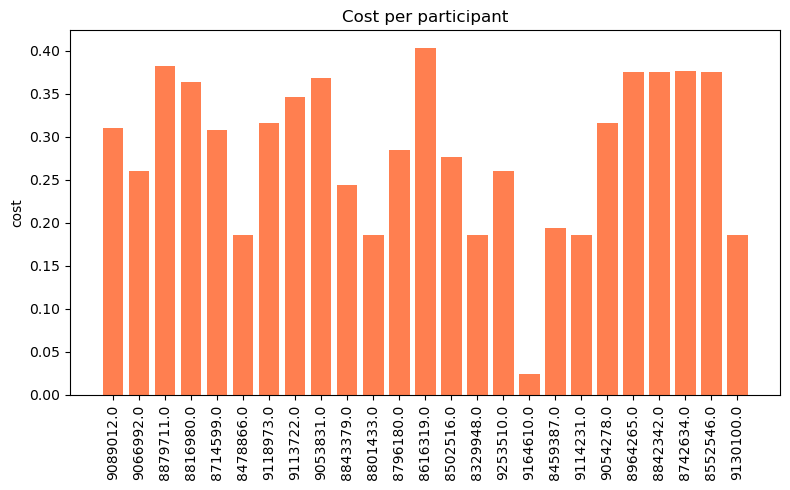

In [10]:
plt.figure(figsize=(8,5))
plt.title('Cost per participant')
string_keys = [str(key) for key in min_cost_sbj.keys()]
plt.bar(string_keys, min_cost_sbj.values(), color='coral')
#plt.ylim(0.0, 0.25)
_=plt.xticks(rotation=90)
_=plt.ylabel('cost')
plt.tight_layout()
os.chdir(fig_path)
plt.savefig('optimizer_costs.svg')

In [11]:
for i in best_pars.items(): 
    print(i)

(9089012.0, array([ 1.00000000e+00, -1.02421974e+00,  4.81171349e-01,  5.55045211e-09,
       -2.62143025e-01, -5.40177801e-09,  2.55750266e-01, -5.40056330e-09,
       -2.13491559e-01,  1.00000000e+00, -1.00000000e+00, -1.47464197e-01,
        2.14422279e-02, -3.73015770e-02,  9.99999995e-01]))
(9066992.0, array([ 1.00000000e+00, -2.25970762e+00, -9.99999995e-01,  3.34363163e-09,
       -5.40177817e-09, -9.90794745e-01,  1.98023972e+00, -8.40067965e-01,
       -5.40177817e-09,  1.00000000e+00, -2.08064361e+00,  9.99999995e-01,
       -5.45283076e-02,  7.22670799e-02,  3.73768604e-09]))
(8879711.0, array([ 1.00000000e+00, -1.00000000e+00, -1.84584140e-01,  3.34363163e-09,
       -5.40177817e-09, -6.59516371e-02,  6.39086823e-02, -5.56566769e-02,
       -5.40177817e-09,  1.00000000e+00, -1.00000000e+00,  9.99999995e-01,
       -1.41818239e-03,  1.50760829e-03,  3.73768604e-09]))
(8816980.0, array([ 3.98386705e+00, -2.40045478e+00, -9.99999995e-01,  3.34363163e-09,
       -5.40177817e-09

In [12]:
soft_pars = {}
for item in best_pars.items():
    sbj_id = item[0]
    soft_sbj = softmax_params(*list(item[1]))
    soft_pars[sbj_id] = soft_sbj
    
df_p = pd.DataFrame.from_dict(soft_pars).T

In [14]:
# catch BDI score and condition for each participant. 
bdi = dict()
conditions = dict()
for sbj in subjects:
    df_sbj = df[df['Participant Private ID'] == sbj]
    sbj_bdi = df_sbj['BDI'].mean()
    condition = df_sbj['Spreadsheet'].unique()[0]
    bdi[sbj] = sbj_bdi
    conditions[sbj] = condition

# determine BDI median split subjects
bdi_median = np.median(list(bdi.values()))
bdi_std = np.std(list(bdi.values()))

low_bdi = [sbj for sbj in subjects if bdi[sbj] < bdi_median]
high_bdi = [sbj for sbj in subjects if bdi[sbj] > bdi_median]

min_bdi = [sbj for sbj in subjects if bdi[sbj] < bdi_median - bdi_std]
max_bdi = [sbj for sbj in subjects if bdi[sbj] > bdi_median + bdi_std]

In [15]:
low_c = [val for key, val in dict(df_p['C']).items() if key in low_bdi]
high_c = [val for key, val in dict(df_p['C']).items() if key in high_bdi]
all_c = [val for key, val in dict(df_p['C']).items()]

In [137]:
# make a function to call the plots

def plot_c_violin(data, title=None, filename=None, A=False, D=False): 
    """
    data should be a list of list
    like low_c above. 
    """

    # Extract the 1st, 2nd, and 3rd elements from each sublist
    p_r0 = [x[0] for x in data]
    p_r1 = [x[1] for x in data]
    p_r2 = [x[2] for x in data]

    # Create a DataFrame to hold the data for plotting
    data = pd.DataFrame({
        'p_r0': p_r0,
        'p_r1': p_r1,
        'p_r2': p_r2
    })

    # violin plots
    plt.figure(figsize=(10, 4))
    if title==None: 
        plt.suptitle(r'$C$: optimized prior on outcomes')
    else:
        plt.suptitle(title)

    # win outcome
    plt.subplot(1, 3, 1)
    color='forestgreen'
    if A==True: 
        color='limegreen'
    ax = sns.violinplot(data=p_r0, color=color)
    for patch in ax.collections:
        patch.set_alpha(0.5)
    if A==True: 
        plt.title(r'$p(return)$|cooperative')
    if D==True: 
        plt.title(r'$p(cooperative)$')
    else: 
        plt.title('win')
    plt.ylim(0.0, 1.0)
    plt.ylabel(r'$p$')

    # loss outocme
    plt.subplot(1, 3, 2)
    color='coral'
    if A==True: 
        color='tomato'
    sns.violinplot(data=p_r1, color=color, alpha=0.2)
    if A==True: 
        plt.title(r'$p(return)$|hostile')
    if D==True: 
        plt.title(r'$p(hostile)$')
    else: 
        plt.title('loss')
    plt.ylim(0.0, 1.)

    # keep outcome
    plt.subplot(1, 3, 3)
    sns.violinplot(data=p_r2)
    
    if A==True: 
        plt.title(r'$p(return)$|random')
        
    if D==True: 
        plt.title(r'$p(random)$')
    else: 
        plt.title('keep budget')
    plt.ylim(0., 1.)
    
    if filename!=None:
        plt.savefig(filename)

    plt.tight_layout()
    plt.show()

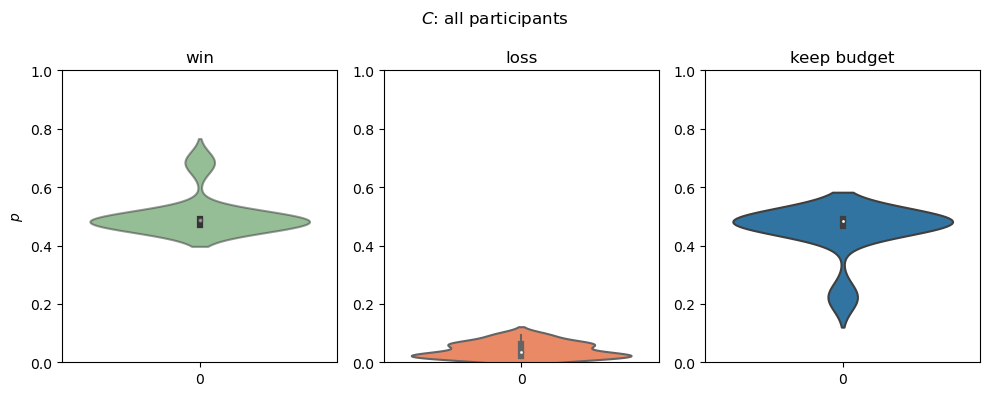

In [17]:
os.chdir(fig_path)
plot_c_violin(all_c, title=str(r'$C$: all participants'), filename='c_violin_all_participants.svg')

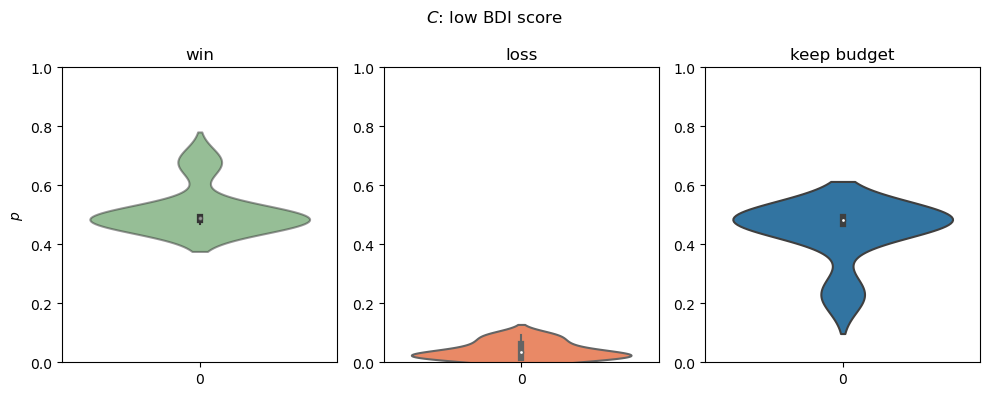

In [18]:
plot_c_violin(low_c, title=str(r'$C$: low BDI score'), filename='c_violin_low_score.svg')

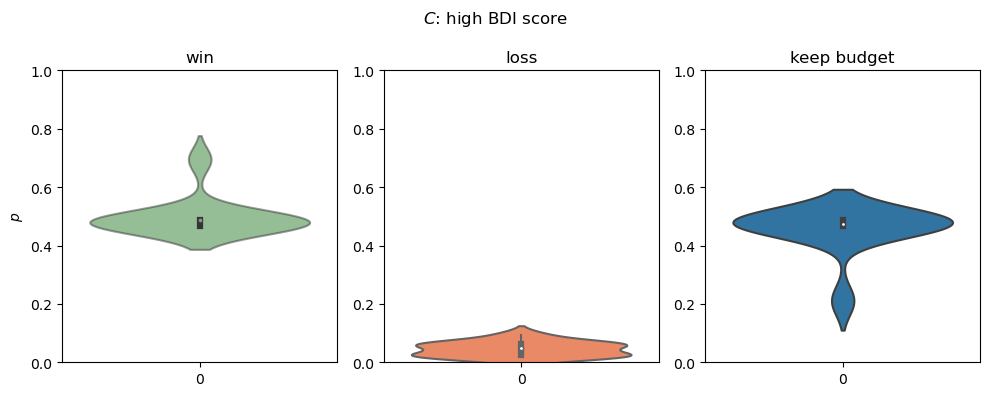

In [19]:
plot_c_violin(high_c, title=str(r'$C$: high BDI score'), filename='c_violin_high_score.svg')

In [111]:
test = [x[0] for x in low_c]

In [112]:
test

[0.6883373636997866,
 0.46900702524231397,
 0.48381400754136017,
 0.48261542344187536,
 0.48968787805412417,
 0.49197619312508367,
 0.6682481509403538,
 0.4919767580077919,
 0.4919734850435693,
 0.4826534899264208,
 0.4683105333473407,
 0.49197662667940534]

In [113]:
# bar plot with the averages for each outcome. 
# Extract the 1st, 2nd, and 3rd elements from each sublist

def make_plottable(input_data): 
    p_r0 = [x[0] for x in input_data]
    p_r1 = [x[1] for x in input_data]
    p_r2 = [x[2] for x in input_data]

    # Create a DataFrame to hold the data for plotting
    data = pd.DataFrame({
        'p_r0': p_r0,
        'p_r1': p_r1,
        'p_r2': p_r2
    })
    
    return data

data_low = make_plottable(low_c)
data_high = make_plottable(high_c)

In [120]:
# determine optimizer area for C outcomes
min_win = softmax([1, -1, 1])[0]
max_win = softmax([4, -4, -1])[0]
print('WIN', min_win, max_win)

min_loss = softmax([4, -4, 1])[1]
max_loss = softmax([1, -1, -1])[1]
print('LOSS', min_loss, max_loss)

min_keep = softmax([4, -1, -1])[2]
max_keep = softmax([1, -4, 1])[2]
print('KEEP', min_keep, max_keep)

WIN 0.4683105308334812 0.9929762720777151
LOSS 0.0003194509383437506 0.10650697891920073
KEEP 0.006648354478866005 0.4983211691867487


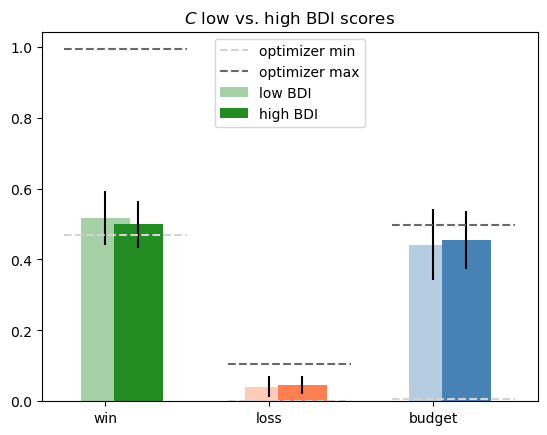

In [125]:
colors = ['forestgreen', 'coral', 'steelblue']
plt.bar(range(1,4), data_low.mean(), width=0.3, color=colors,alpha=0.4, yerr=data_low.std(), label='low BDI')
plt.bar([l + 0.2 for l in list(range(1,4))], data_high.mean(), width=0.3, color=colors, yerr=data_high.std(), label='high BDI')
_=plt.xticks(range(1,4), labels=['win', 'loss', 'budget'])

# opt areas for win
plt.hlines(min_win, 0.75, 1.5, linestyle='dashed', color='lightgrey', label='optimizer min')
plt.hlines(max_win, 0.75, 1.5, linestyle='dashed', color='dimgray', label='optimizer max')

# opt areas for loss
plt.hlines(min_loss, 1.75, 2.5, linestyle='dashed', color='lightgrey')
plt.hlines(max_loss, 1.75, 2.5, linestyle='dashed', color='dimgray')

# optimizer areas for keep 
plt.hlines(min_keep, 2.75, 3.5, linestyle='dashed', color='lightgrey')
plt.hlines(max_keep, 2.75, 3.5, linestyle='dashed', color='dimgray')

plt.legend(loc='upper center')
plt.title(r'$C$ low vs. high BDI scores')
os.chdir(fig_path)
plt.savefig('c_low_high_bar.svg')

In [122]:
# c for different conditions. pn, np, rand. 
# get list of subject names for all conditions. 
np_sbj   = [sbj for sbj, val in conditions.items() if val=='Negative-to-positive'] 
pn_sbj   = [sbj for sbj, val in conditions.items() if val=='Positive-to-negative']
rand_sbj = [sbj for sbj, val in conditions.items() if val=='Ambigious']

# catch c data per condition.
np_c = [val for key, val in dict(df_p['C']).items() if key in np_sbj]
pn_c = [val for key, val in dict(df_p['C']).items() if key in pn_sbj]
rand_c = [val for key, val in dict(df_p['C']).items() if key in rand_sbj]

data_np = make_plottable(np_c)
data_pn = make_plottable(pn_c)
data_rand  = make_plottable(rand_c)

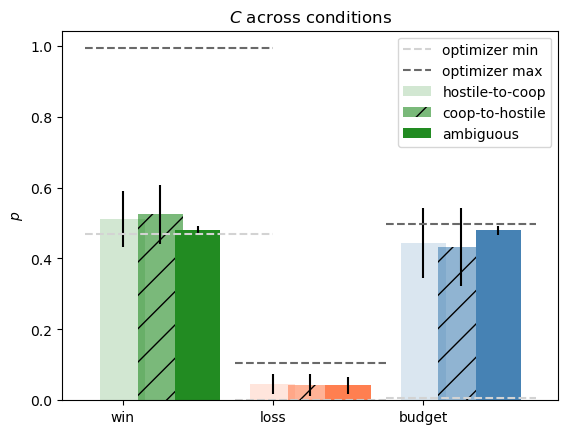

In [127]:
cols = ['forestgreen', 'coral', 'steelblue']
plt.bar(range(1,4), data_np.mean(), width=0.3, color=cols,alpha=0.2, yerr=data_np.std(), label='hostile-to-coop')
plt.bar([l + 0.25 for l in list(range(1,4))], data_pn.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', yerr=data_pn.std(), label='coop-to-hostile')
plt.bar([l + 0.5 for l in list(range(1,4))], data_rand.mean(), width=0.3, color=cols, yerr=data_rand.std(), label='ambiguous')

# opt areas for win
plt.hlines(min_win, 0.75, 2.0, linestyle='dashed', color='lightgrey', label='optimizer min')
plt.hlines(max_win, 0.75, 2.0, linestyle='dashed', color='dimgray', label='optimizer max')

# opt areas for loss
plt.hlines(min_loss, 1.75, 2.75, linestyle='dashed', color='lightgrey')
plt.hlines(max_loss, 1.75, 2.75, linestyle='dashed', color='dimgray')

# optimizer areas for keep 
plt.hlines(min_keep, 2.75, 3.75, linestyle='dashed', color='lightgrey')
plt.hlines(max_keep, 2.75, 3.75, linestyle='dashed', color='dimgray')

plt.legend(loc='upper right')
_=plt.xticks(range(1,4), labels=['win', 'loss', 'budget'])
plt.title(r'$C$ across conditions')
plt.ylabel(r'$p$')
os.chdir(fig_path)
plt.savefig('c_conditions_bar.svg')

In [128]:
# D plots. 
low_d = [val for key, val in dict(df_p['D']).items() if key in low_bdi]
high_d = [val for key, val in dict(df_p['D']).items() if key in high_bdi]
all_d = [val for key, val in dict(df_p['D']).items()]

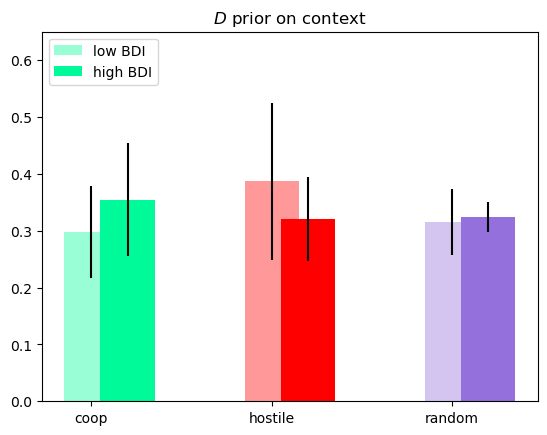

In [129]:
data_low = make_plottable(low_d)
data_high = make_plottable(high_d)

cols = ['mediumspringgreen', 'red', 'mediumpurple']

plt.bar(range(1,4), data_low.mean(), width=0.3, color=cols,alpha=0.4, yerr=data_low.std(), label='low BDI')
plt.bar([l + 0.2 for l in list(range(1,4))], data_high.mean(), width=0.3, color=cols, yerr=data_high.std(), label='high BDI')
plt.legend(loc='upper left')
plt.ylim(0, 0.65)
_=plt.xticks(range(1,4), labels=['coop', 'hostile', 'random'])
plt.title(r'$D$ prior on context')
os.chdir(fig_path)
plt.savefig('D_bdi_mediansplit.svg')

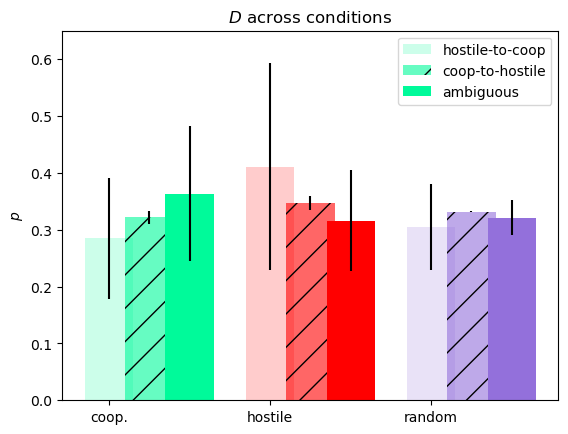

In [27]:
# catch c data per condition.
np_d = [val for key, val in dict(df_p['D']).items() if key in np_sbj]
pn_d = [val for key, val in dict(df_p['D']).items() if key in pn_sbj]
rand_d = [val for key, val in dict(df_p['D']).items() if key in rand_sbj]

data_np = make_plottable(np_d)
data_pn = make_plottable(pn_d)
data_rand  = make_plottable(rand_d)

plt.bar(range(1,4), data_np.mean(), width=0.3, color=cols,alpha=0.2, yerr=data_np.std(), label='hostile-to-coop')
plt.bar([l + 0.25 for l in list(range(1,4))], data_pn.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', yerr=data_pn.std(), label='coop-to-hostile')
plt.bar([l + 0.5 for l in list(range(1,4))], data_rand.mean(), width=0.3, color=cols, yerr=data_rand.std(), label='ambiguous')

plt.legend(loc='upper right')
_=plt.xticks(range(1,4), labels=['coop.', 'hostile', 'random'])
plt.title(r'$D$ across conditions')
plt.ylabel(r'$p$')
plt.ylim(0, 0.65)
os.chdir(fig_path)
plt.savefig('D_per_conditions_bar.svg')

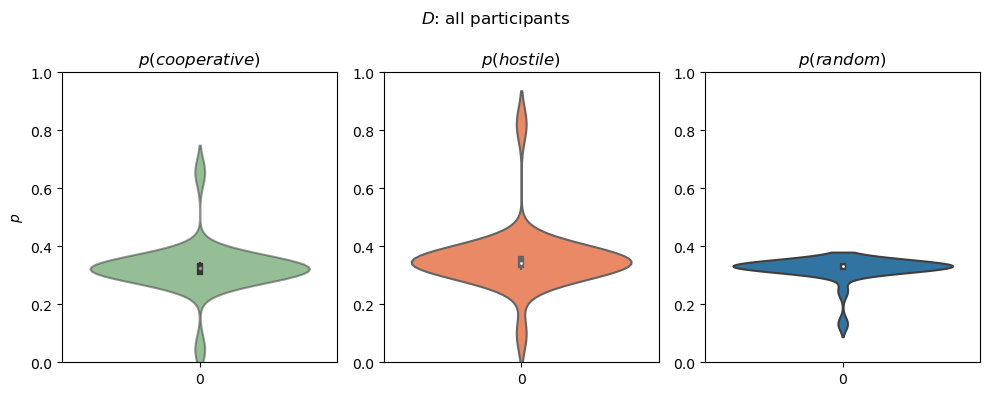

In [138]:
plot_c_violin(all_d, title=str(r'$D$: all participants'), filename='D_all_participants.svg', D=True)

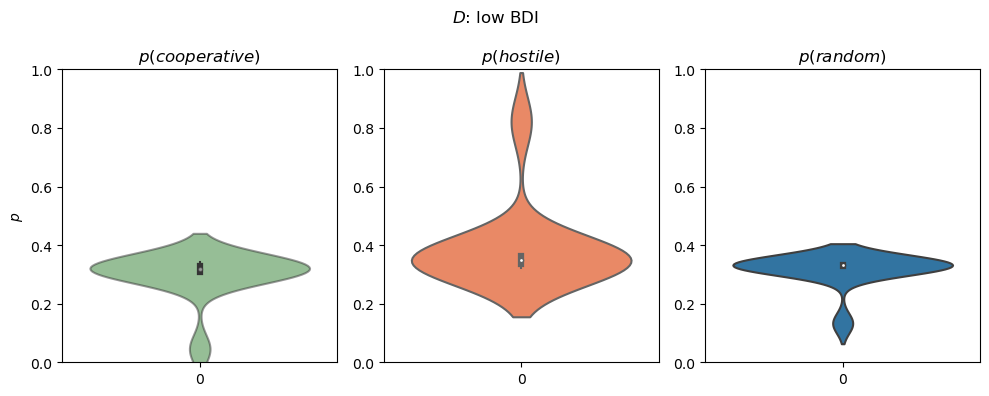

In [139]:
plot_c_violin(low_d, title=str(r'$D$: low BDI'), filename='D_low_bdi.svg', D=True)

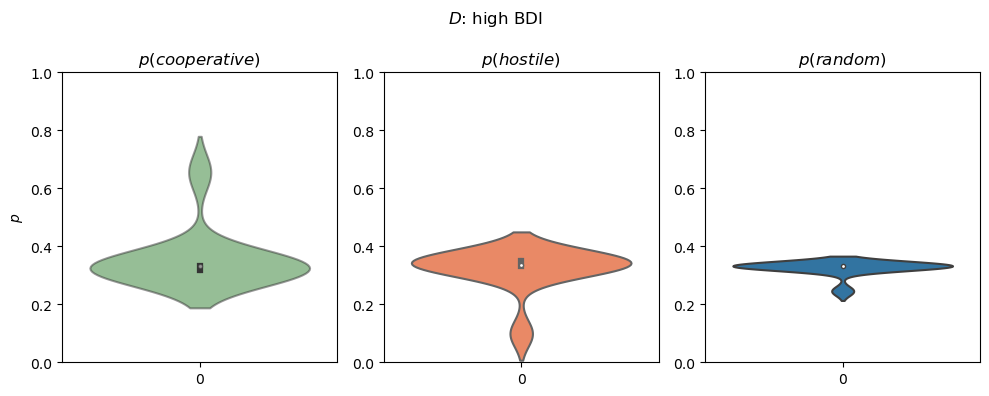

In [140]:
plot_c_violin(high_d, title=str(r'$D$: high BDI'), filename='D_high_bdi.svg', D=True)

In [28]:
# plot p_share_friendly, p_share_hostile and p_share_random... as violin. 
low_a = [val for key, val in dict(df_p['A']).items() if key in low_bdi]
high_a = [val for key, val in dict(df_p['A']).items() if key in high_bdi]
all_a = [val for key, val in dict(df_p['A']).items()]

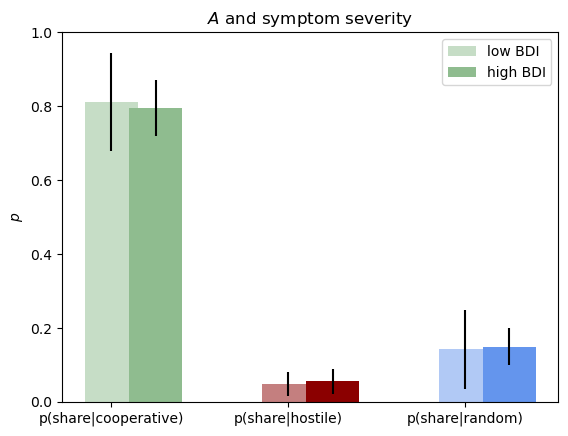

In [204]:
data_low = make_plottable(low_a)
data_high = make_plottable(high_a)
data_all  = make_plottable(all_a)

cols = ['darkseagreen', 'darkred', 'cornflowerblue']

plt.bar(range(1,4), data_low.mean(), width=0.3, color=cols,alpha=0.5, yerr=data_np.std(), label='low BDI')
plt.bar([l + 0.25 for l in list(range(1,4))], data_high.mean(), alpha=1., width=0.3, color=cols, 
        yerr=data_pn.std(), label='high BDI')
#plt.bar([l + 0.5 for l in list(range(1,4))], data_rand.mean(), width=0.3, color=cols, yerr=data_rand.std(), label='')

plt.legend(loc='upper right')
_=plt.xticks(range(1,4), labels=['p(share|cooperative)', 'p(share|hostile)', 'p(share|random)'])
plt.title(r'$A$ and symptom severity')
plt.ylabel(r'$p$')
plt.ylim(0, 1)
os.chdir(fig_path)
plt.savefig('A_low_high_BDI.svg')

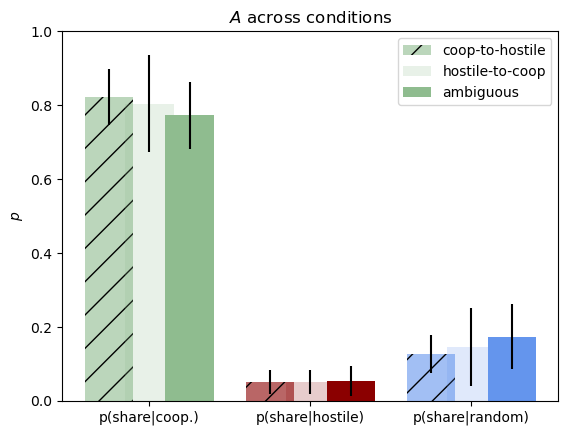

In [207]:
# catch c data per condition.
np_a = [val for key, val in dict(df_p['A']).items() if key in np_sbj]
pn_a = [val for key, val in dict(df_p['A']).items() if key in pn_sbj]
rand_a = [val for key, val in dict(df_p['A']).items() if key in rand_sbj]

data_np = make_plottable(np_a)
data_pn = make_plottable(pn_a)
data_rand  = make_plottable(rand_a)


plt.bar(np.arange(1,4,1), data_pn.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', 
        yerr=data_pn.std(), label='coop-to-hostile')
plt.bar(np.arange(1.25,4.25, 1), data_np.mean(), width=0.3, color=cols,alpha=0.2, yerr=data_np.std(), label='hostile-to-coop')
plt.bar(np.arange(1.5,4.5,1), data_rand.mean(), width=0.3, color=cols, 
        yerr=data_rand.std(), label='ambiguous')

plt.legend(loc='upper right')
_=plt.xticks(np.arange(1.25,4.25,1), labels=['p(share|coop.)', 'p(share|hostile)', 'p(share|random)'])
plt.title(r'$A$ across conditions')
plt.ylabel(r'$p$')
plt.ylim(0, 1)
os.chdir(fig_path)
plt.savefig('A_per_conditions_bar.svg')

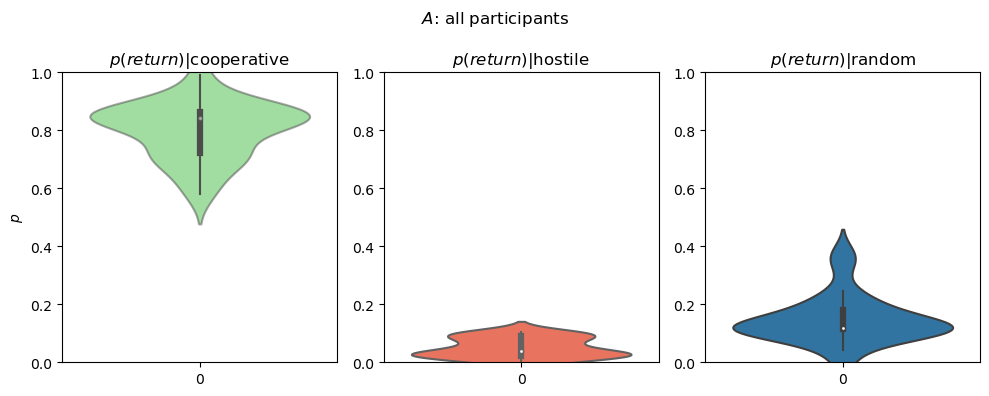

In [33]:
# plot violin plot of A parameters
plot_c_violin(all_a, title=str(r'$A$: all participants'), filename='A_violin_all_participants.svg', A=True)

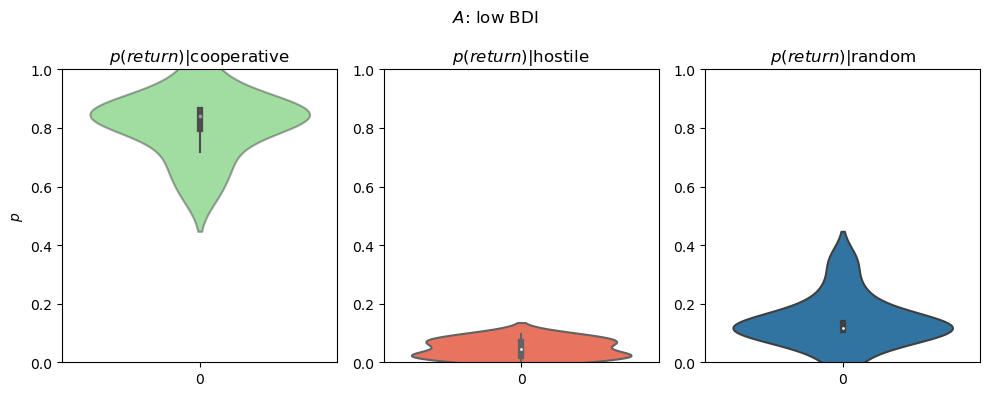

In [34]:
plot_c_violin(low_a, title=str(r'$A$: low BDI'), filename='a_violin_lowBDI.svg', A=True)

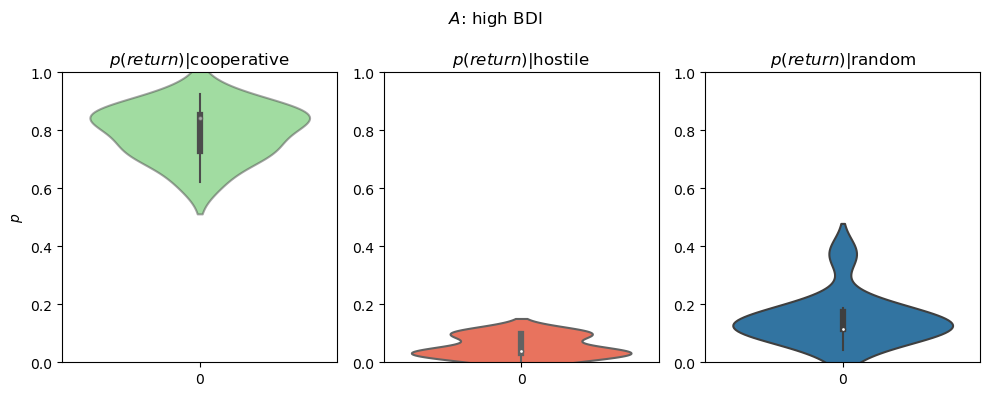

In [35]:
plot_c_violin(high_a, title=str(r'$A$: high BDI'), filename='a_violin_highBDI.svg', A=True)

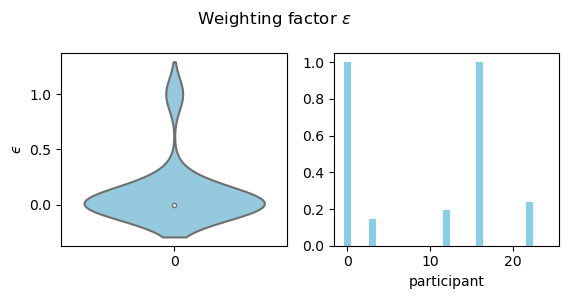

In [64]:
epsilons = []
for item in soft_pars.items(): 
    epsilons.append(item[1]['ep'])

fig, axs = plt.subplots(1,2)
fig.set_figheight(3)
fig.set_figwidth(6)
sns.violinplot(epsilons, ax=axs[0], color='skyblue')
axs[0].set_ylabel(r'$ϵ$')

axs[1].bar(range(0,len(epsilons)),epsilons, color='skyblue')
axs[1].set_xlabel('participant')

fig.suptitle(r'Weighting factor $\epsilon$')
plt.tight_layout()
plt.savefig('epsilon.svg')

In [159]:
# B: transition matrix parameters. 
soft_B_sbj = dict()

for sbj in subjects: 
    params = list(dict(df_p['B'])[sbj])
    soft_B = make_soft_B(*params)
    soft_B_sbj[sbj] = soft_B
    

In [169]:
df_p['B']

9089012.0    [0.5651630229466781, 0.43483697705332186, 0.43...
9066992.0    [0.5000000021863524, 0.4999999978136475, 0.048...
8879711.0    [0.5000000021863524, 0.4999999978136475, 0.467...
8816980.0    [0.5000000021863524, 0.4999999978136475, 0.007...
8714599.0    [0.5000000021863524, 0.4999999978136475, 0.152...
8478866.0    [0.5000000027480875, 0.4999999972519125, 0.024...
9118973.0    [0.5000000021863524, 0.4999999978136475, 0.186...
9113722.0    [0.5000000021865036, 0.49999999781349636, 0.34...
9053831.0    [0.5000000021848068, 0.49999999781519316, 0.43...
8843379.0    [0.5000000021863524, 0.4999999978136475, 0.040...
8801433.0    [0.5000000027483368, 0.4999999972516633, 0.024...
8796180.0    [0.5000000021863524, 0.4999999978136475, 0.073...
8616319.0    [0.5067722978273442, 0.49322770217265577, 0.49...
8502516.0    [0.5000000021863524, 0.4999999978136475, 0.067...
8329948.0    [0.5000000027486596, 0.4999999972513404, 0.024...
9253510.0    [0.5000000021863524, 0.4999999978136475, 0

In [161]:
sbj_friendly, sbj_hostile, sbj_random = {},{},{}

for sbj in subjects:
    friendly = soft_B_sbj[sbj][:, :1, :].flatten()
    hostile  = soft_B_sbj[sbj][:, 1:2, :].flatten()
    random   = soft_B_sbj[sbj][:, 2:3, :].flatten()
    
    sbj_friendly[sbj] = friendly
    sbj_hostile[sbj]  = hostile
    sbj_random[sbj]   = random
  

In [174]:
sbj_friendly

{9089012.0: array([0.40881793, 0.35886413, 0.23231794]),
 9066992.0: array([0.38365173, 0.38365173, 0.23269654]),
 8879711.0: array([0.38365173, 0.38365173, 0.23269654]),
 8816980.0: array([0.38365173, 0.38365173, 0.23269654]),
 8714599.0: array([0.38365173, 0.38365173, 0.23269654]),
 8478866.0: array([0.38365173, 0.38365173, 0.23269654]),
 9118973.0: array([0.38365173, 0.38365173, 0.23269654]),
 9113722.0: array([0.38365173, 0.38365173, 0.23269654]),
 9053831.0: array([0.38365173, 0.38365173, 0.23269654]),
 8843379.0: array([0.38365173, 0.38365173, 0.23269654]),
 8801433.0: array([0.38365173, 0.38365173, 0.23269654]),
 8796180.0: array([0.38365173, 0.38365173, 0.23269654]),
 8616319.0: array([0.38625196, 0.3810556 , 0.23269244]),
 8502516.0: array([0.38365173, 0.38365173, 0.23269654]),
 8329948.0: array([0.38365173, 0.38365173, 0.23269654]),
 9253510.0: array([0.38365173, 0.38365173, 0.23269654]),
 9164610.0: array([0.41228299, 0.35550957, 0.23220743]),
 8459387.0: array([0.38365173, 

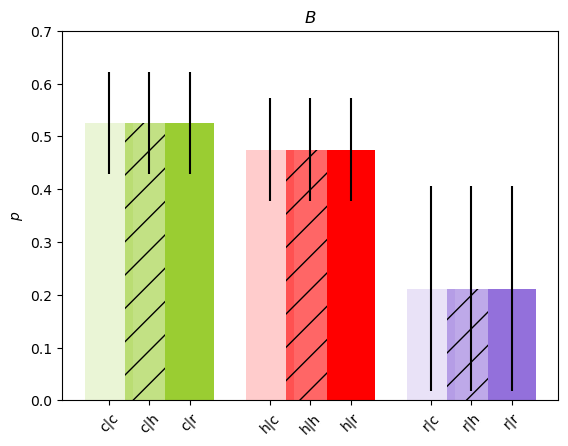

In [194]:
# catch B data per condition.
b_friendly = [val for key, val in dict(df_p['B']).items() if key in sbj_friendly]
b_hostile = [val for key, val in dict(df_p['B']).items() if key in sbj_hostile]
b_random = [val for key, val in dict(df_p['B']).items() if key in sbj_random]

data_b_friendly = make_plottable(b_friendly)
data_b_hostile = make_plottable(b_hostile)
data_b_random  = make_plottable(b_random)

cols = ['yellowgreen', 'red', 'mediumpurple']

plt.bar(range(1,4), data_b_friendly.mean(), width=0.3, color=cols,alpha=0.2, 
        yerr=data_b_friendly.std())


plt.bar([l + 0.25 for l in list(range(1,4))], data_b_hostile.mean(), alpha=0.6, width=0.3, color=cols, hatch='/', 
        yerr=data_b_hostile.std())


plt.bar([l + 0.5 for l in list(range(1,4))], data_b_random.mean(), width=0.3, color=cols, 
        yerr=data_b_random.std())

#plt.legend(loc='upper right')

x_positions = range(1, 4)
# Combine all xticks positions and labels
xtick_positions = list(x_positions) + [l + 0.25 for l in x_positions] + [l + 0.5 for l in x_positions]
xtick_labels = ['c|c', 'h|c', 'r|c', 'c|h', 'h|h', 'r|h', 'c|r', 'h|r', 'r|r']

# Set all xticks at once
plt.xticks(xtick_positions, labels=xtick_labels, rotation=45)

plt.title(r'$B$')
plt.ylabel(r'$p$')
plt.ylim(0, 0.7)
os.chdir(fig_path)
plt.savefig('B_all_together.svg')

In [152]:
# last thing: find the average parameters (ABCD) for highly depressed vs. lowly depressed and simulate agent with them. 
sorted_bdi = sorted(bdi.items(), key=lambda item: item[1])

min_bdi = sorted_bdi[:3]
max_bdi = sorted_bdi[-3:]

min_bdi_sbj = [sbj for sbj,score in min_bdi]
max_bdi_sbj = [sbj for sbj,score in max_bdi]

In [153]:
dict(df_p.loc[min_bdi_sbj]['C'])

{9118973.0: [0.48261542344187536, 0.034769158024984814, 0.48261541853313983],
 8842342.0: [0.4683105333473407, 0.06337893806855767, 0.46831052858410177],
 9089012.0: [0.6883373636997866, 0.09315633119006661, 0.21850630511014688]}

In [154]:
dict(df_p.loc[max_bdi_sbj]['C'])

{9113722.0: [0.47518844446235475, 0.04962311590871083, 0.4751884396289344],
 9066992.0: [0.48877535320000887, 0.0224492985713712, 0.48877534822862],
 8742634.0: [0.46831053334727357, 0.0633789380686918, 0.4683105285840347]}

In [155]:
np.mean([0.507, 0.34, 0.33])

0.39233333333333337

In [156]:
np.mean([0.28, 0.35, 0.33])

0.32

In [157]:
conditions

{9089012.0: 'Negative-to-positive',
 9066992.0: 'Negative-to-positive',
 8879711.0: 'Negative-to-positive',
 8816980.0: 'Negative-to-positive',
 8714599.0: 'Negative-to-positive',
 8478866.0: 'Negative-to-positive',
 9118973.0: 'Negative-to-positive',
 9113722.0: 'Positive-to-negative',
 9053831.0: 'Positive-to-negative',
 8843379.0: 'Positive-to-negative',
 8801433.0: 'Positive-to-negative',
 8796180.0: 'Positive-to-negative',
 8616319.0: 'Positive-to-negative',
 8502516.0: 'Positive-to-negative',
 8329948.0: 'Positive-to-negative',
 9253510.0: 'Positive-to-negative',
 9164610.0: 'Positive-to-negative',
 8459387.0: 'Ambigious',
 9114231.0: 'Ambigious',
 9054278.0: 'Ambigious',
 8964265.0: 'Ambigious',
 8842342.0: 'Ambigious',
 8742634.0: 'Ambigious',
 8552546.0: 'Ambigious',
 9130100.0: 'Ambigious'}